# <Font color = 'indianred'>**Specify Project Folder**

In [1]:
# add lines for autoreload
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/')
    data_folder = Path('/content')

    !pip install pytorch-lightning -U -qq
    !pip install torchinfo -U -qq

else:
    base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor')
    data_folder = Path('/home/harpreet/data')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 17.8 MB/s eta 0:00:00


In [3]:
custom_function_folder = base_folder/'data/custom-functions/fall_2023/'
sys.path.append(str(custom_function_folder))
model_folder = base_folder/'data/models/dl_fall_2023/fmnist'
model_folder.mkdir(parents=True, exist_ok=True)

# <Font color = 'indianred'>**Import Libraries**

In [4]:
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
import torchmetrics

import torch.nn.functional as F
# from data_loaders_fmnist import get_loaders
from data_module_fmnist import FashionMNISTDataModule
from model_two_layer import TwoLayerMLP
from shared_utils import check_loader, check_transforms, check_label_dist, show_confusion_matrix, compute_accuracy, plot_losses_acc
from datetime import datetime




# <Font color = 'indianred'>**Get dataloaders**

In [5]:
# Define preprocessing transformations for training and testing datasets
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.2857,), (0.3528)),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.2857,), (0.3528)),
        ]
    ),
}

In [6]:
####NEW######
torch.manual_seed(123)
dm = FashionMNISTDataModule(data_dir=data_folder, train_transform=data_transforms['train'], test_transform=data_transforms['test'],
                 batch_size=256, seed=42, fraction_train=0.8)

In [7]:
dm.prepare_data()

100%|██████████| 26421880/26421880 [00:00<00:00, 114731207.05it/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4696137.57it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 67885615.96it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7389554.07it/s]


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [8]:
dm.setup(stage='fit')
check_loader(dm.train_dataloader())

 Batch Number: 1 | Batch size: 256 | x shape: torch.Size([256, 1, 28, 28]) | y shape: torch.Size([256])
 Batch Number: 2 | Batch size: 256 | x shape: torch.Size([256, 1, 28, 28]) | y shape: torch.Size([256])
 Batch Number: 3 | Batch size: 256 | x shape: torch.Size([256, 1, 28, 28]) | y shape: torch.Size([256])

Labels from current batch 
 tensor([7, 6, 7, 3, 7, 3, 5, 3, 8, 1, 0, 3, 3, 3, 9, 1, 9, 1, 2, 4, 4, 9, 9, 8,
        1, 0, 4, 7, 2, 3, 7, 3, 7, 8, 9, 4, 7, 4, 0, 3, 4, 0, 4, 2, 4, 0, 2, 0,
        1, 3, 1, 9, 4, 4, 0, 7, 0, 6, 5, 4, 3, 8, 5, 6, 1, 8, 1, 5, 4, 7, 5, 5,
        1, 7, 3, 6, 7, 7, 6, 9, 1, 5, 0, 6, 8, 3, 2, 1, 5, 7, 8, 8, 7, 8, 0, 1,
        4, 4, 7, 4, 3, 3, 7, 3, 9, 5, 8, 3, 7, 0, 0, 8, 4, 6, 4, 3, 7, 8, 2, 7,
        6, 8, 4, 0, 7, 1, 9, 5, 3, 6, 9, 2, 2, 8, 7, 1, 4, 8, 0, 9, 0, 1, 9, 6,
        7, 5, 8, 3, 4, 1, 5, 8, 5, 9, 6, 5, 5, 1, 1, 1, 7, 2, 2, 2, 9, 6, 7, 5,
        1, 3, 5, 3, 0, 4, 6, 3, 8, 5, 4, 2, 1, 3, 3, 9, 2, 8, 0, 8, 7, 5, 1, 1,
        7, 4, 7, 8,

In [9]:
dm.setup(stage='fit')
check_loader(dm.val_dataloader())

 Batch Number: 1 | Batch size: 256 | x shape: torch.Size([256, 1, 28, 28]) | y shape: torch.Size([256])
 Batch Number: 2 | Batch size: 256 | x shape: torch.Size([256, 1, 28, 28]) | y shape: torch.Size([256])
 Batch Number: 3 | Batch size: 256 | x shape: torch.Size([256, 1, 28, 28]) | y shape: torch.Size([256])

Labels from current batch 
 tensor([8, 5, 4, 2, 9, 5, 3, 7, 8, 8, 9, 0, 5, 0, 1, 4, 0, 2, 5, 7, 5, 5, 4, 0,
        7, 9, 8, 2, 4, 8, 4, 1, 4, 7, 4, 5, 6, 3, 4, 8, 5, 0, 9, 6, 4, 6, 0, 0,
        9, 0, 9, 0, 8, 2, 2, 3, 0, 1, 2, 7, 0, 0, 5, 9, 7, 0, 0, 6, 9, 3, 5, 3,
        3, 3, 8, 1, 3, 9, 3, 4, 3, 8, 8, 8, 4, 5, 3, 5, 2, 0, 2, 2, 1, 9, 4, 0,
        3, 7, 0, 6, 5, 0, 7, 8, 4, 4, 6, 3, 5, 3, 3, 7, 3, 8, 4, 5, 9, 1, 8, 7,
        5, 8, 3, 8, 4, 4, 4, 5, 6, 4, 6, 9, 8, 4, 2, 2, 0, 9, 1, 3, 1, 1, 7, 8,
        7, 2, 6, 4, 4, 3, 1, 2, 1, 3, 9, 3, 4, 1, 3, 3, 3, 6, 5, 9, 0, 2, 1, 8,
        6, 4, 0, 7, 5, 2, 7, 1, 9, 5, 1, 9, 2, 5, 9, 6, 3, 8, 2, 6, 4, 6, 5, 0,
        5, 3, 7, 1,

In [10]:
dm.setup(stage='test')
check_loader(dm.test_dataloader())

 Batch Number: 1 | Batch size: 256 | x shape: torch.Size([256, 1, 28, 28]) | y shape: torch.Size([256])
 Batch Number: 2 | Batch size: 256 | x shape: torch.Size([256, 1, 28, 28]) | y shape: torch.Size([256])
 Batch Number: 3 | Batch size: 256 | x shape: torch.Size([256, 1, 28, 28]) | y shape: torch.Size([256])

Labels from current batch 
 tensor([6, 1, 9, 8, 5, 1, 9, 1, 2, 8, 3, 8, 9, 2, 4, 2, 8, 8, 2, 0, 5, 8, 8, 5,
        3, 9, 4, 3, 4, 4, 5, 1, 0, 1, 2, 0, 6, 9, 6, 1, 5, 1, 1, 1, 9, 3, 4, 5,
        3, 6, 6, 6, 4, 6, 0, 5, 8, 3, 3, 4, 6, 7, 7, 8, 9, 0, 3, 8, 7, 6, 7, 9,
        3, 4, 6, 6, 5, 0, 1, 1, 5, 9, 4, 6, 5, 7, 8, 1, 2, 9, 7, 7, 1, 0, 9, 3,
        2, 9, 0, 7, 6, 8, 2, 7, 0, 2, 3, 8, 2, 2, 6, 9, 3, 0, 7, 8, 6, 2, 9, 4,
        2, 6, 6, 8, 0, 4, 4, 4, 7, 5, 8, 4, 9, 1, 0, 5, 4, 4, 4, 0, 0, 4, 5, 6,
        0, 4, 5, 4, 1, 3, 1, 1, 6, 4, 3, 8, 2, 8, 2, 7, 0, 4, 0, 8, 5, 0, 8, 2,
        9, 0, 8, 9, 6, 4, 2, 9, 3, 4, 5, 0, 9, 5, 3, 6, 6, 8, 3, 3, 8, 1, 4, 0,
        9, 7, 9, 4,

In [11]:
dm.setup(stage='fit')
check_transforms(dm.train_dataloader())

shape of inputs is :torch.Size([256, 1, 28, 28])

max input value  :2.0246598720550537

min input value  :-0.8098071813583374

mean input value  :0.01937456987798214

std input value  :1.0166703462600708

shape of targets is :torch.Size([256])

inputs  :tensor([[-0.8098, -0.8098, -0.8098, -0.3318,  0.3129],
        [-0.8098, -0.8098, -0.6320,  0.4685, -0.0873],
        [-0.8098, -0.8098, -0.8098,  0.3907, -0.7098],
        [-0.8098, -0.8098, -0.8098,  0.3684, -0.4319],
        [-0.8098, -0.8098, -0.1095,  0.2684,  1.1465]])


In [12]:
check_label_dist(dm.train_dataloader())


 Label distribution:


[(0, 4713),
 (1, 4738),
 (2, 4817),
 (3, 4843),
 (4, 4791),
 (5, 4783),
 (6, 4783),
 (7, 4847),
 (8, 4792),
 (9, 4765)]

In [13]:
class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = model
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        inputs, labels = batch
        output = self(inputs)
        loss = F.cross_entropy(output, labels)
        predicted_labels = torch.argmax(output, dim=1)
        return loss, labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)

        # Log at every 50 steps
        if batch_idx % 50 == 0:
            self.log("train_loss_step", loss, on_step=True, on_epoch=False)

        self.train_acc(predicted_labels, labels)

        # Log for the epoch average
        self.log("train_loss_epoch", loss, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_acc, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)
        self.log("val_loss", loss, on_epoch=True, on_step=False)
        self.val_acc(predicted_labels, labels)
        self.log("val_acc", self.val_acc, prog_bar=True, on_epoch=True, on_step=False)

    def on_train_epoch_end(self):
        metrics = self.trainer.callback_metrics

        # Using 'train_loss_epoch' to get the average loss for the epoch
        print(f"Train_Loss: {metrics['train_loss_epoch']:.2f}, Train_Acc: {metrics['train_acc']:.2f}")

    def on_validation_epoch_end(self):
        metrics = self.trainer.callback_metrics
        epoch_num = self.current_epoch
        print(f"Epoch {epoch_num + 1}: Val_Loss: {metrics['val_loss']:.2f}, Val_Acc: {metrics['val_acc']:.2f}" ,end=" | ", flush=True)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

    def test_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, labels)
        self.log("test_acc", self.test_acc)



# <Font color = 'indianred'>**Train Model**

In [14]:
# Define the model architecture and training parameters
num_features = 1*28*28
hidden_dim1 = 200
hidden_dim2 = 100
num_classes = 10
epochs = 10
learning_rate = 0.03


# Set a random seed for reproducibility
torch.manual_seed(42)

# Create the neural network model
model = TwoLayerMLP(num_features, hidden_dim1, hidden_dim2, num_classes)

lightning_model = LightningModel(model=model, learning_rate=learning_rate)


# Determine the computing device (CPU or GPU) to use
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

summary(model, (1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
TwoLayerMLP                              [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 200]                  157,000
│    └─ReLU: 2-3                         [1, 200]                  --
│    └─Linear: 2-4                       [1, 100]                  20,100
│    └─ReLU: 2-5                         [1, 100]                  --
│    └─Linear: 2-6                       [1, 10]                   1,010
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.71
Estimated Total Size (MB): 0.72

In [15]:
trainer = pl.Trainer(
        max_epochs=10,
        accelerator="auto",  # set to "auto" or "gpu" to use GPUs if available
        devices="auto",  # Uses all available GPUs if applicable
        deterministic=True,
        logger=CSVLogger(save_dir=model_folder/'logs', name="two_layer")
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(
        model=lightning_model,
        datamodule=dm,
    )

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | TwoLayerMLP        | 178 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
178 K     Trainable params
0         Non-trainable params
178 K     Total params
0.712     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: Val_Loss: 2.31, Val_Acc: 0.15 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.65, Val_Acc: 0.77 | Train_Loss: 1.05, Train_Acc: 0.68


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.54, Val_Acc: 0.81 | Train_Loss: 0.58, Train_Acc: 0.79


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.49, Val_Acc: 0.83 | Train_Loss: 0.50, Train_Acc: 0.82


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.46, Val_Acc: 0.83 | Train_Loss: 0.46, Train_Acc: 0.84


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.45, Val_Acc: 0.84 | Train_Loss: 0.44, Train_Acc: 0.84


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.44, Val_Acc: 0.84 | Train_Loss: 0.42, Train_Acc: 0.85


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 0.41, Val_Acc: 0.86 | Train_Loss: 0.40, Train_Acc: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 0.41, Val_Acc: 0.86 | Train_Loss: 0.39, Train_Acc: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.40, Val_Acc: 0.86 | Train_Loss: 0.38, Train_Acc: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 0.40, Val_Acc: 0.86 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Train_Loss: 0.37, Train_Acc: 0.87


# <Font color = 'indianred'>**Plot Losses**

In [17]:
file = f"{trainer.logger.log_dir}/metrics.csv"

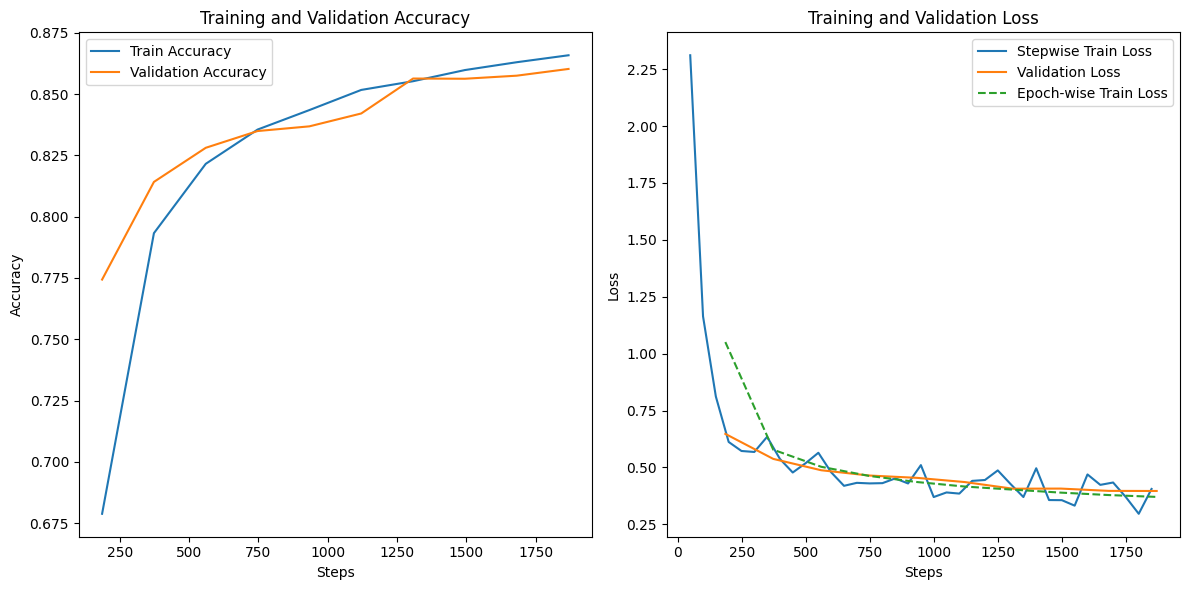

In [18]:
plot_losses_acc(file)

In [19]:
# plot_history(train_losses=lightning_model.epoch_train_losses, val_losses = lightning_model.epoch_val_losses[1:])

# <Font color = 'indianred'>**Evaluation**

In [20]:
train_acc = trainer.validate(dataloaders=dm.train_dataloader())

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/two_layer/version_19/checkpoints/epoch=9-step=1870.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/two_layer/version_19/checkpoints/epoch=9-step=1870.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connec

Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.37, Val_Acc: 0.87 | 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8678768277168274     │
│         val_loss          │     0.365887314081192     │
└───────────────────────────┴───────────────────────────┘

In [21]:
train_acc

[{'val_loss': 0.365887314081192, 'val_acc': 0.8678768277168274}]

In [22]:
train_acc = trainer.validate(dataloaders=dm.train_dataloader())[0]["val_acc"]
val_acc = trainer.validate(datamodule=dm)[0]["val_acc"]
test_acc = trainer.test(datamodule=dm)[0]["test_acc"]


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/two_layer/version_19/checkpoints/epoch=9-step=1870.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/two_layer/version_19/checkpoints/epoch=9-step=1870.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.37, Val_Acc: 0.87 | 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.867855966091156     │
│         val_loss          │    0.36621272563934326    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/two_layer/version_19/checkpoints/epoch=9-step=1870.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/two_layer/version_19/checkpoints/epoch=9-step=1870.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.40, Val_Acc: 0.86 | 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8602499961853027     │
│         val_loss          │    0.39640799164772034    │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/two_layer/version_19/checkpoints/epoch=9-step=1870.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/data/models/dl_fall_2023/fmnist/logs/two_layer/version_19/checkpoints/epoch=9-step=1870.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: 

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8478999733924866     │
└───────────────────────────┴───────────────────────────┘

In [23]:
print(
    f"Train Acc {train_acc*100:.2f}%"
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)

Train Acc 86.79% | Val Acc 86.02% | Test Acc 84.79%
